C:\Users\pc\AppData\Local\Temp\ipykernel_9844\380485562.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce')
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.


            mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau     5386.296  33.257  5342.000  5417.000      2.032   14.056     799.0   
mu1        0.000   0.000    -0.000     0.001      0.000    0.000   10161.0   
mu2       -0.000   0.000    -0.001     0.001      0.000    0.000    9929.0   
sigma1     0.023   0.000     0.023     0.023      0.000    0.000    8705.0   
sigma2     0.029   0.000     0.028     0.029      0.000    0.000    6116.0   

        ess_tail  r_hat  
tau        756.0    1.0  
mu1       5796.0    1.0  
mu2       6087.0    1.0  
sigma1    5316.0    1.0  
sigma2    3396.0    1.0  


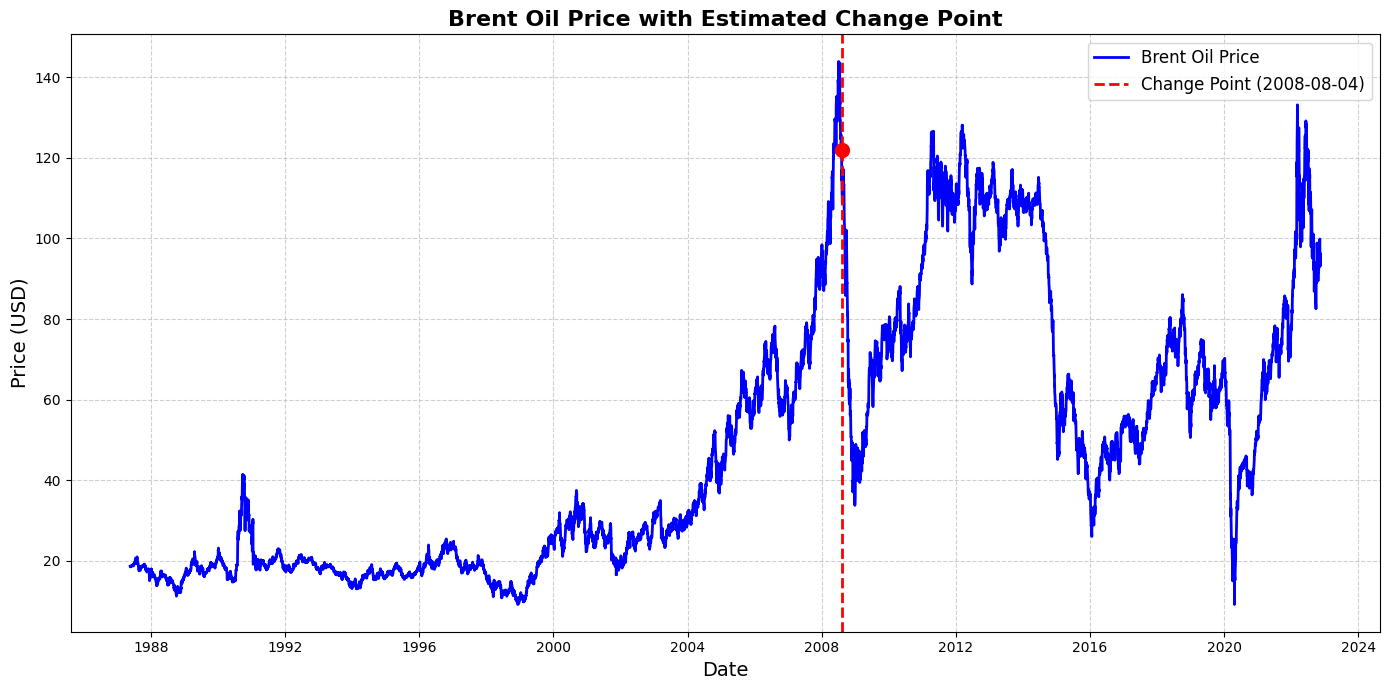

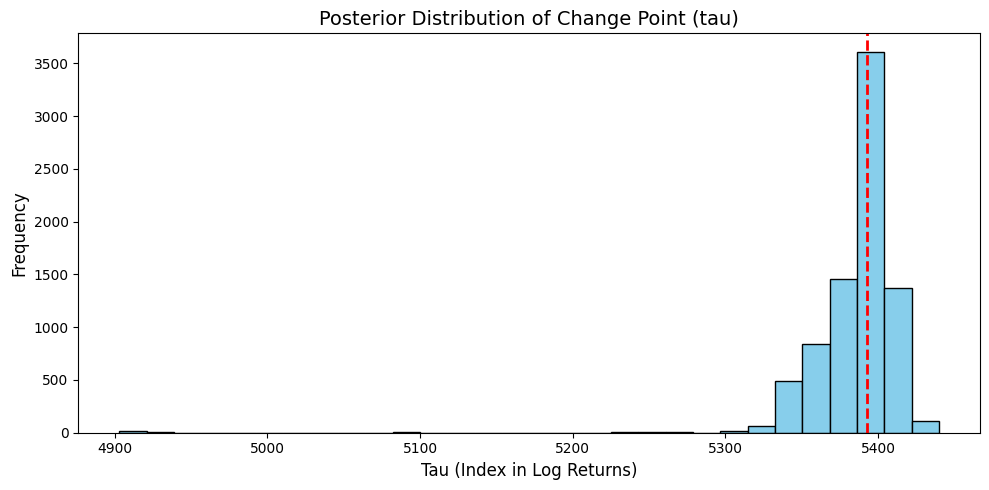

In [4]:
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import pytensor.tensor as at
import matplotlib.pyplot as plt
import os

# === Load data ===
brent_df = pd.read_csv(
    "C:/Users/pc/Desktop/10 Academy/Week 10/Brentoil/data/brent_prices.csv",
    parse_dates=['Date'],
    date_format='%d-%m-%Y'  # Using new recommended parameter
)

# ✅ Ensure Date column is datetime
brent_df['Date'] = pd.to_datetime(brent_df['Date'], errors='coerce')

# Sort and calculate log returns
brent_df = brent_df.sort_values('Date')
brent_df['LogReturn'] = np.log(brent_df['Price']).diff()
log_returns = brent_df['LogReturn'].dropna().values
time_idx_tt = at.arange(len(log_returns))

# === Bayesian Change Point Model ===
with pm.Model() as model:
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(log_returns) - 1)

    mu1 = pm.Normal('mu1', mu=0, sigma=0.01)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.01)

    sigma1 = pm.HalfNormal('sigma1', sigma=0.01)
    sigma2 = pm.HalfNormal('sigma2', sigma=0.01)

    mu = pm.math.switch(tau >= time_idx_tt, mu1, mu2)
    sigma = pm.math.switch(tau >= time_idx_tt, sigma1, sigma2)

    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=log_returns)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# === Save model results directory ===
os.makedirs("outputs/model_results", exist_ok=True)
az.to_netcdf(trace, 'outputs/model_results/trace.nc')

# === Model summary ===
summary_df = az.summary(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])
print(summary_df)
summary_df.to_csv("outputs/model_results/summary.csv")  # Save summary as CSV

# === Extract most likely change point date ===
tau_samples = trace.posterior['tau'].values.flatten()
most_likely_tau = int(np.median(tau_samples))
most_likely_date = brent_df['Date'].iloc[1 + most_likely_tau]  # +1 for dropped first row in log return
most_likely_date = pd.to_datetime(most_likely_date)  # Ensure datetime format

# === Improved Change Point Plot ===
plt.figure(figsize=(14, 7))
plt.plot(
    brent_df['Date'], brent_df['Price'],
    color="blue", linewidth=2, label="Brent Oil Price"
)
plt.axvline(
    most_likely_date, color='red', linestyle='--', linewidth=2,
    label=f"Change Point ({most_likely_date.date()})"
)

# Highlight the change point
plt.scatter(
    most_likely_date,
    brent_df.loc[brent_df['Date'] == most_likely_date, 'Price'].values[0],
    color="red", s=100, zorder=5
)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.title("Brent Oil Price with Estimated Change Point", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("outputs/model_results/change_point_plot.png", dpi=300)  # Save plot
plt.show()

# === Posterior plot for tau ===
plt.figure(figsize=(10, 5))
plt.hist(tau_samples, bins=30, color="skyblue", edgecolor="black")
plt.axvline(most_likely_tau, color="red", linestyle="--", linewidth=2)
plt.title("Posterior Distribution of Change Point (tau)", fontsize=14)
plt.xlabel("Tau (Index in Log Returns)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.savefig("outputs/model_results/tau_posterior_hist.png", dpi=300)  # Save histogram
plt.show()
